# Using COPASI via BasiCO

This notebook demonstrates how to apply pyABC to models simulated via [COPASI](http://copasi.org/), using the Python interface [BasiCO](https://basico.readthedocs.io/en/latest/index.html).

In [ ]:
# install if not done yet
!pip install pyabc[copasi] --quiet

In [2]:
from pyabc.copasi import BasicoModel
import pyabc

import numpy as np
import matplotlib.pyplot as plt
import tempfile

pyabc.settings.set_figure_params('pyabc')  # for beautified plots

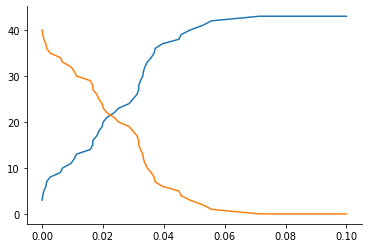

In [3]:
max_t = 0.1
model = BasicoModel("models/model1.xml", duration=max_t)

true_par = {"rate": 2.3}
obs = model(true_par)
plt.plot(obs["t"], obs["X"]);

As usual, we define a distance and a prior distribution.

In [4]:
n_test_times = 20
t_test_times = np.linspace(0, max_t, n_test_times)

def distance(x, y):
    xt_ind = np.searchsorted(x["t"], t_test_times) - 1
    yt_ind = np.searchsorted(y["t"], t_test_times) - 1
    error = (
        np.absolute(x["X"][:, 1][xt_ind] - y["X"][:, 1][yt_ind]).sum()
        / t_test_times.size
    )
    return error

prior = pyabc.Distribution(rate=pyabc.RV("uniform", 0, 50))

We are all set to run an analysis:

In [5]:
abc = pyabc.ABCSMC(model, prior, distance, population_size=100)
db = tempfile.mkstemp(suffix=".db")[1]
abc.new("sqlite:///" + db, obs)
h = abc.run(max_nr_populations=10, min_acceptance_rate=1e-2)

ABC.Sampler INFO: Parallelize sampling on 4 processes.
INFO:ABC.Sampler:Parallelize sampling on 4 processes.
ABC.History INFO: Start <ABCSMC id=1, start_time=2021-12-05 12:15:57>
INFO:ABC.History:Start <ABCSMC id=1, start_time=2021-12-05 12:15:57>
ABC INFO: Calibration sample t = -1.
INFO:ABC:Calibration sample t = -1.
ABC INFO: t: 0, eps: 8.95000000e+00.
INFO:ABC:t: 0, eps: 8.95000000e+00.
ABC INFO: Accepted: 100 / 208 = 4.8077e-01, ESS: 1.0000e+02.
INFO:ABC:Accepted: 100 / 208 = 4.8077e-01, ESS: 1.0000e+02.
ABC INFO: t: 1, eps: 8.25000000e+00.
INFO:ABC:t: 1, eps: 8.25000000e+00.
ABC INFO: Accepted: 100 / 206 = 4.8544e-01, ESS: 9.6966e+01.
INFO:ABC:Accepted: 100 / 206 = 4.8544e-01, ESS: 9.6966e+01.
ABC INFO: t: 2, eps: 6.55009972e+00.
INFO:ABC:t: 2, eps: 6.55009972e+00.
ABC INFO: Accepted: 100 / 250 = 4.0000e-01, ESS: 9.5430e+01.
INFO:ABC:Accepted: 100 / 250 = 4.0000e-01, ESS: 9.5430e+01.
ABC INFO: t: 3, eps: 5.09217796e+00.
INFO:ABC:t: 3, eps: 5.09217796e+00.
ABC INFO: Accepted: 100 

As usual, we can now analyze the results. Posterior approximation over time:

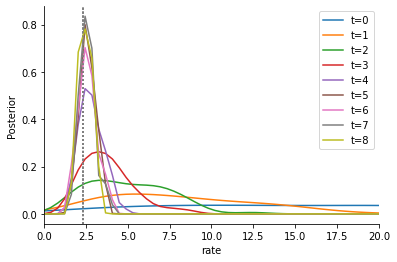

In [6]:
fig, ax = plt.subplots()

for t in range(h.max_t):
    pyabc.visualization.plot_kde_1d_highlevel(
        h, x="rate", xmin=0, xmax=20, t=t,
        refval=true_par, refval_color="grey",
        label=f"t={t}", ax=ax,
    )
ax.legend();

Accepted simulations at the beginning and at the end:

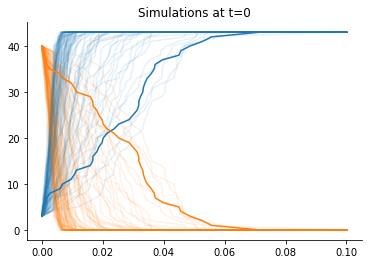

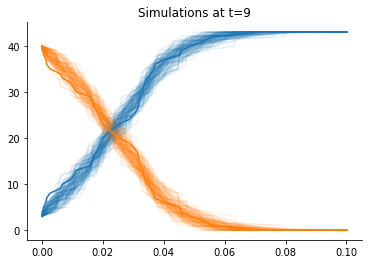

In [7]:
def plot_data(sumstat, weight, ax, **kwargs):
    """Plot a single trajectory"""
    for i in range(2):
        ax.plot(sumstat["t"], sumstat['X'][:, i], color=f"C{i}", alpha=0.1)

for t in [0, h.max_t]:
    _, ax = plt.subplots()
    pyabc.visualization.plot_data_callback(
        h, plot_data, t=t, ax=ax,
    )
    ax.plot(obs["t"], obs["X"])
    ax.set_title(f"Simulations at t={t}"); 